<a href="https://colab.research.google.com/github/Govind-Asawa/US_Car_Accidents/blob/master/ML_US_Car_accidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import math
import re
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# READING THE CSV
df = pd.read_csv('/content/gdrive/MyDrive/CSCE - 5215 - ML Project/balanced_sample_df.csv')

**Columns we do not need:** ID, source, timezone, Description, street, country, airport_code, weather_timestamp, civil_twilight, nautical_twilight, astronomical_twilight

In [ ]:
df.columns = df.columns.map(lambda col: col.lower())

df = df.drop(
    ['id', 'source', 'timezone', 'end_lat', 'end_lng', 'description', 'street', 'country', 'airport_code', 'weather_timestamp',
     'civil_twilight', 'nautical_twilight', 'astronomical_twilight'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533514 entries, 0 to 533513
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   severity           533514 non-null  int64  
 1   start_time         533514 non-null  object 
 2   end_time           533514 non-null  object 
 3   start_lat          533514 non-null  float64
 4   start_lng          533514 non-null  float64
 5   distance(mi)       533514 non-null  float64
 6   city               533486 non-null  object 
 7   county             533514 non-null  object 
 8   state              533514 non-null  object 
 9   zipcode            533339 non-null  object 
 10  temperature(f)     520967 non-null  float64
 11  wind_chill(f)      387511 non-null  float64
 12  humidity(%)        520177 non-null  float64
 13  pressure(in)       522698 non-null  float64
 14  visibility(mi)     519830 non-null  float64
 15  wind_direction     520669 non-null  object 
 16  wi

## Univarite analysis
The first task is to identify the type of each column i.e., continuous or categorical values

Categorical values

- severity (target col)
- city
- county
- state
- zipcode
- wind_direction
- weather_condition
- sunrise_sunset
- -> (All bool type)

Continuous

- distance(mi)
- temperature(f)
- wind_chill(f)
- humidity(%)
- pressure(in)
- visibility(mi)
- wind_speed(mph)
- precipitation(in)

Date -> need to be converted to date type

- start_time
- end_time

In [ ]:
print("Unique weather conditions")
print(df['weather_condition'].unique())

print("\n\nNo. of Unique weather conditions", len(df['weather_condition'].unique()))

Unique weather conditions
['Overcast' 'Light Rain' 'Clear' 'Light Snow' 'Scattered Clouds'
 'Mostly Cloudy' 'Haze' nan 'Rain' 'Light Freezing Drizzle'
 'Partly Cloudy' 'Light Freezing Fog' 'Snow' 'Fog' 'Heavy Rain'
 'Light Drizzle' 'Thunderstorms and Rain' 'Smoke' 'Fair' 'Cloudy'
 'Blowing Sand' 'Widespread Dust' 'Rain Showers' 'Drizzle'
 'Showers in the Vicinity' 'Light Thunderstorms and Rain' 'Mist'
 'Patches of Fog' 'Thunderstorm' 'Heavy Thunderstorms and Rain'
 'Thunder in the Vicinity' 'Thunder' 'Light Freezing Rain' 'Shallow Fog'
 'Heavy Snow' 'Light Ice Pellets' 'Partly Cloudy / Windy' 'Light Fog'
 'Fair / Windy' 'Ice Pellets' 'Small Hail' 'Heavy T-Storm' 'Funnel Cloud'
 'Light Rain Showers' 'T-Storm' 'Light Rain with Thunder'
 'Heavy T-Storm / Windy' 'Thunder / Windy' 'Light Rain / Windy'
 'Mostly Cloudy / Windy' 'Cloudy / Windy' 'T-Storm / Windy'
 'Heavy Rain / Windy' 'Haze / Windy' 'Tornado' 'Light Rain Shower'
 'N/A Precipitation' 'Drizzle and Fog' 'Light Drizzle / Windy'
 '

In [ ]:
val_counts = df['weather_condition'].value_counts()
val_counts = val_counts.sort_values(ascending=False)

print("--> Top 20 weather conditions")
print(val_counts.iloc[:20])

print("\n--> Least 20 repeating weather conditions")
print(val_counts.iloc[-20:])

--> Top 20 weather conditions
Fair                       169250
Mostly Cloudy               71084
Clear                       60247
Cloudy                      55213
Partly Cloudy               47928
Overcast                    29628
Light Rain                  24367
Scattered Clouds            15148
Light Snow                   8760
Fog                          6204
Rain                         5776
Haze                         4237
Fair / Windy                 2413
Heavy Rain                   2241
Light Drizzle                1686
T-Storm                      1153
Thunder in the Vicinity      1139
Cloudy / Windy               1130
Snow                         1128
Mostly Cloudy / Windy        1107
Name: weather_condition, dtype: int64

--> Least 20 repeating weather conditions
Light Snow with Thunder         2
Patches of Fog / Windy          2
Heavy Sleet                     2
Drifting Snow / Windy           2
Thunderstorms and Snow          1
Volcanic Ash                    1
Heavy

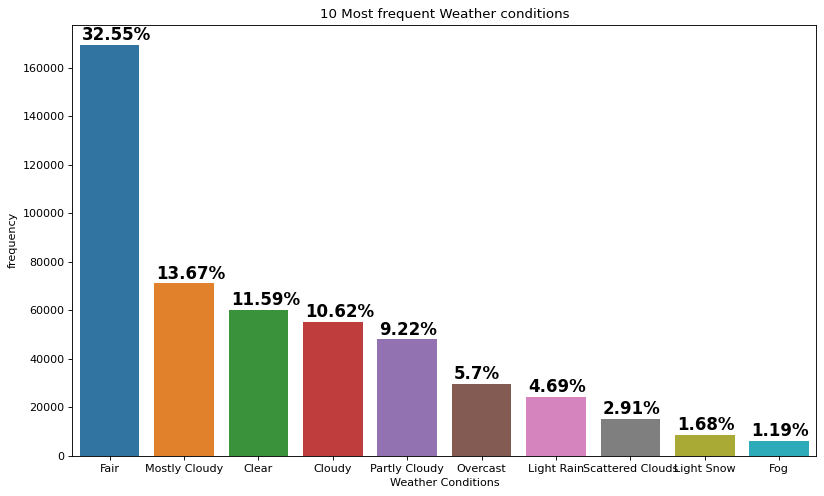

In [ ]:
fig, ax = plt.subplots(figsize = (12,7), dpi = 80)
sns.barplot(x=val_counts.index[:10], y=val_counts.iloc[:10])

total = val_counts.sum()

for i in ax.patches:
    ax.text(i.get_x()+.03, i.get_height()+2000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15, weight='bold',
                color='black')

plt.title("10 Most frequent Weather conditions")
plt.xlabel("Weather Conditions")
plt.ylabel("frequency")
plt.show()

Weather condition

- Has 106 unqiue categorical values
- Around 10 values cover almost 90% of the samples, rest rarely appear

- Y do we need to process this?
  - Since the data has been pulled from various APIs many diff values might have almost similar interpretation
  - Defining relative order among the values can be very diff inorder to apply label/ordinal encoding
  - one-hot will create a lot of sparse data
- Possible Solution?
  - Retain only the most common values and drop the others
  - Carefully aggregate various values into broad categories

In [ ]:
print("Unique wind directions")
print(df['wind_direction'].unique())

Unique wind directions
['SSE' 'East' 'WNW' 'South' 'SE' 'West' 'NW' 'SSW' 'WSW' 'SW' 'Calm' nan
 'NE' 'ESE' 'NNE' 'Variable' 'NNW' 'ENE' 'North' 'E' 'S' 'CALM' 'VAR' 'N'
 'W']


![Reading wind directions](	https://www.surfertoday.com/images/stories/compassrose.jpg)

Wind Direction
- we have a lot of different unqiue values
- But a few are just duplicates i.e., West and W are the same, North & N are the same similarly, S & South, E & East, CALM & Calm, Variable & VAR

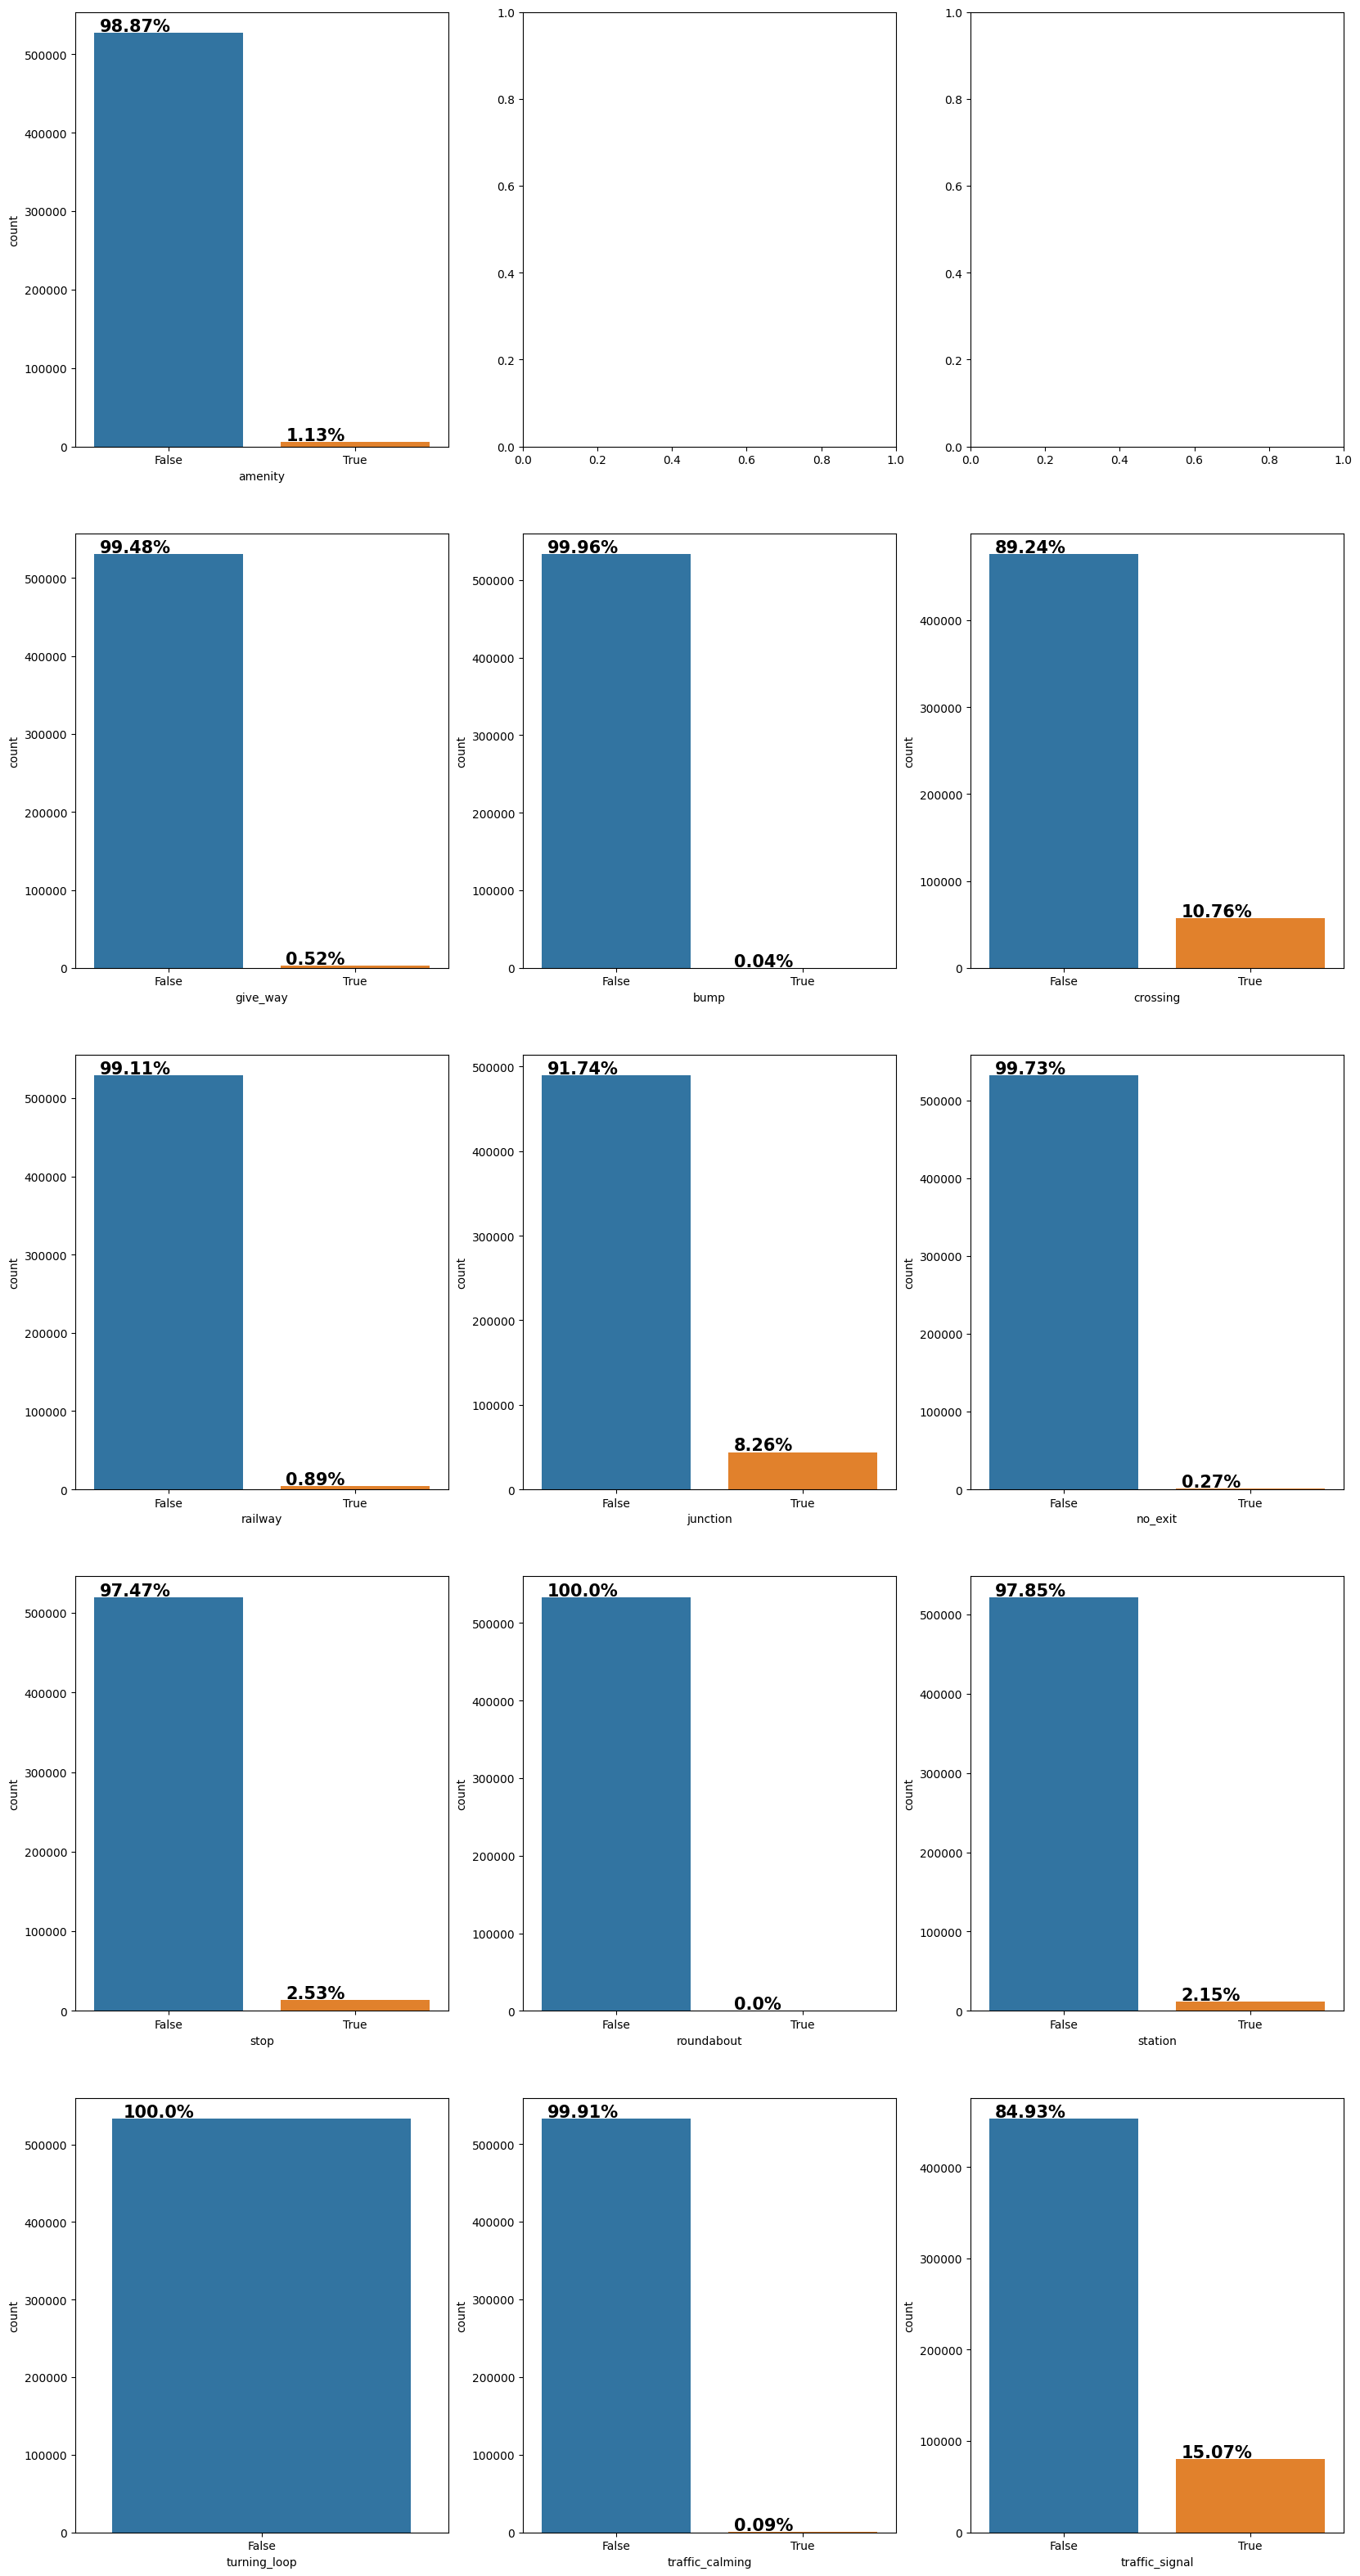

In [ ]:
N_PLOTS_PER_ROW = 3
bool_type_cols = df.select_dtypes('bool').columns
nbool_cols = len(bool_type_cols)
nrows = math.ceil(nbool_cols/N_PLOTS_PER_ROW)

fig, axs = plt.subplots(nrows=nrows, ncols=N_PLOTS_PER_ROW, figsize=(20, 40))

total = df.shape[0]

for i, col in enumerate(bool_type_cols):
    r = math.ceil(i/N_PLOTS_PER_ROW)
    c = i%N_PLOTS_PER_ROW
    axes = axs[r][c]
    sns.countplot(data=df, x = col, ax = axes)

    #writing percentages on each bar
    for p in axes.patches:
        axes.text(p.get_x()+.03, p.get_height()+2000, \
            str(round((p.get_height()/total)*100, 2))+'%', fontsize=15, weight='bold',
                color='black')

plt.show()

All boolean data observation

- False constitutes majority of the data

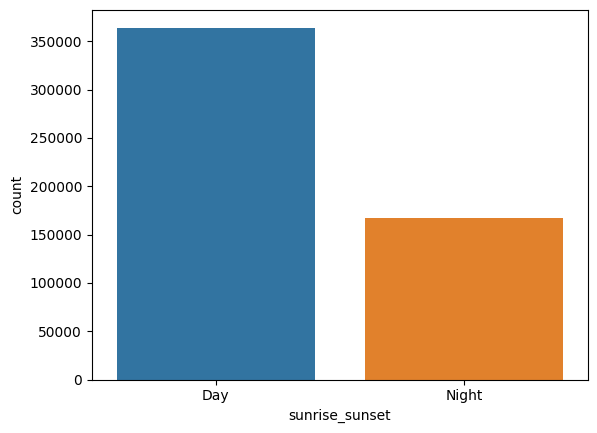

In [ ]:
sns.countplot(data = df, x = 'sunrise_sunset')
plt.show()

**Observation**
- Signals that majority of accidents are happening during the day time

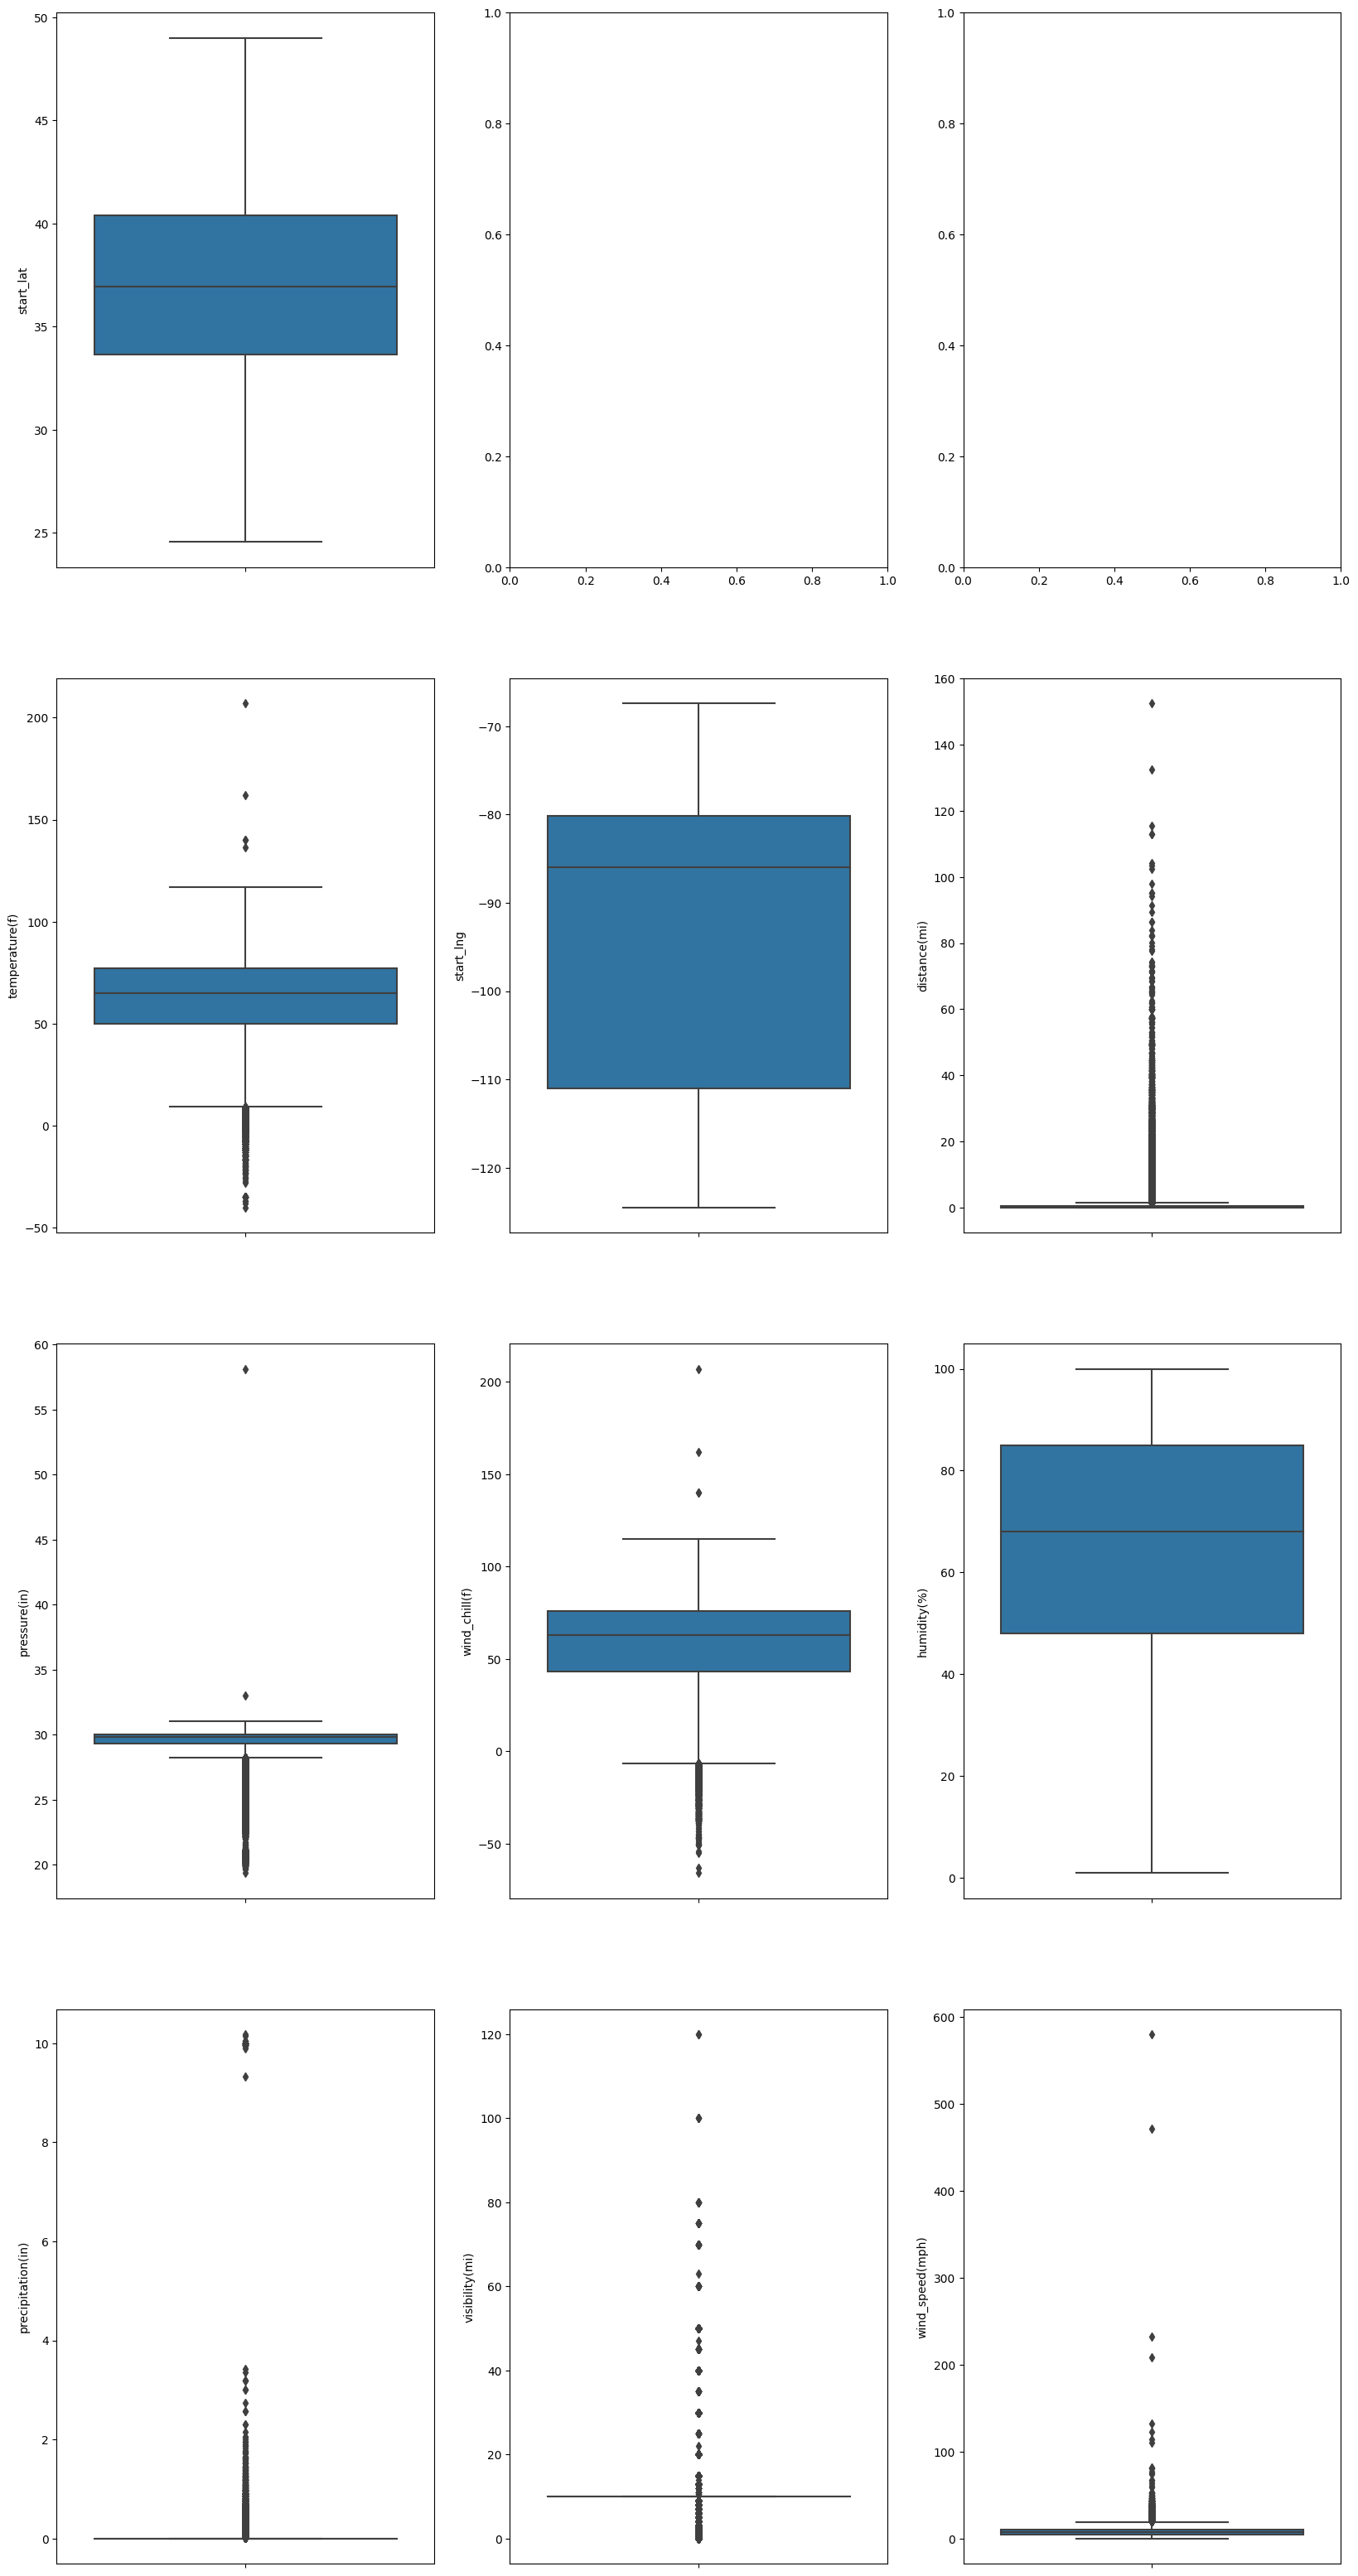

In [ ]:
N_PLOTS_PER_ROW = 3
cont_type_cols = df.select_dtypes('float64').columns
ncont_cols = len(cont_type_cols)
nrows = math.ceil(ncont_cols/N_PLOTS_PER_ROW)

fig, axs = plt.subplots(nrows=nrows, ncols=N_PLOTS_PER_ROW, figsize=(20, 40))

total = df.shape[0]

for i, col in enumerate(cont_type_cols):
    r = math.ceil(i/N_PLOTS_PER_ROW)
    c = i%N_PLOTS_PER_ROW
    axes = axs[r][c]
    sns.boxplot(data=df, y = col, ax = axes)

plt.show()

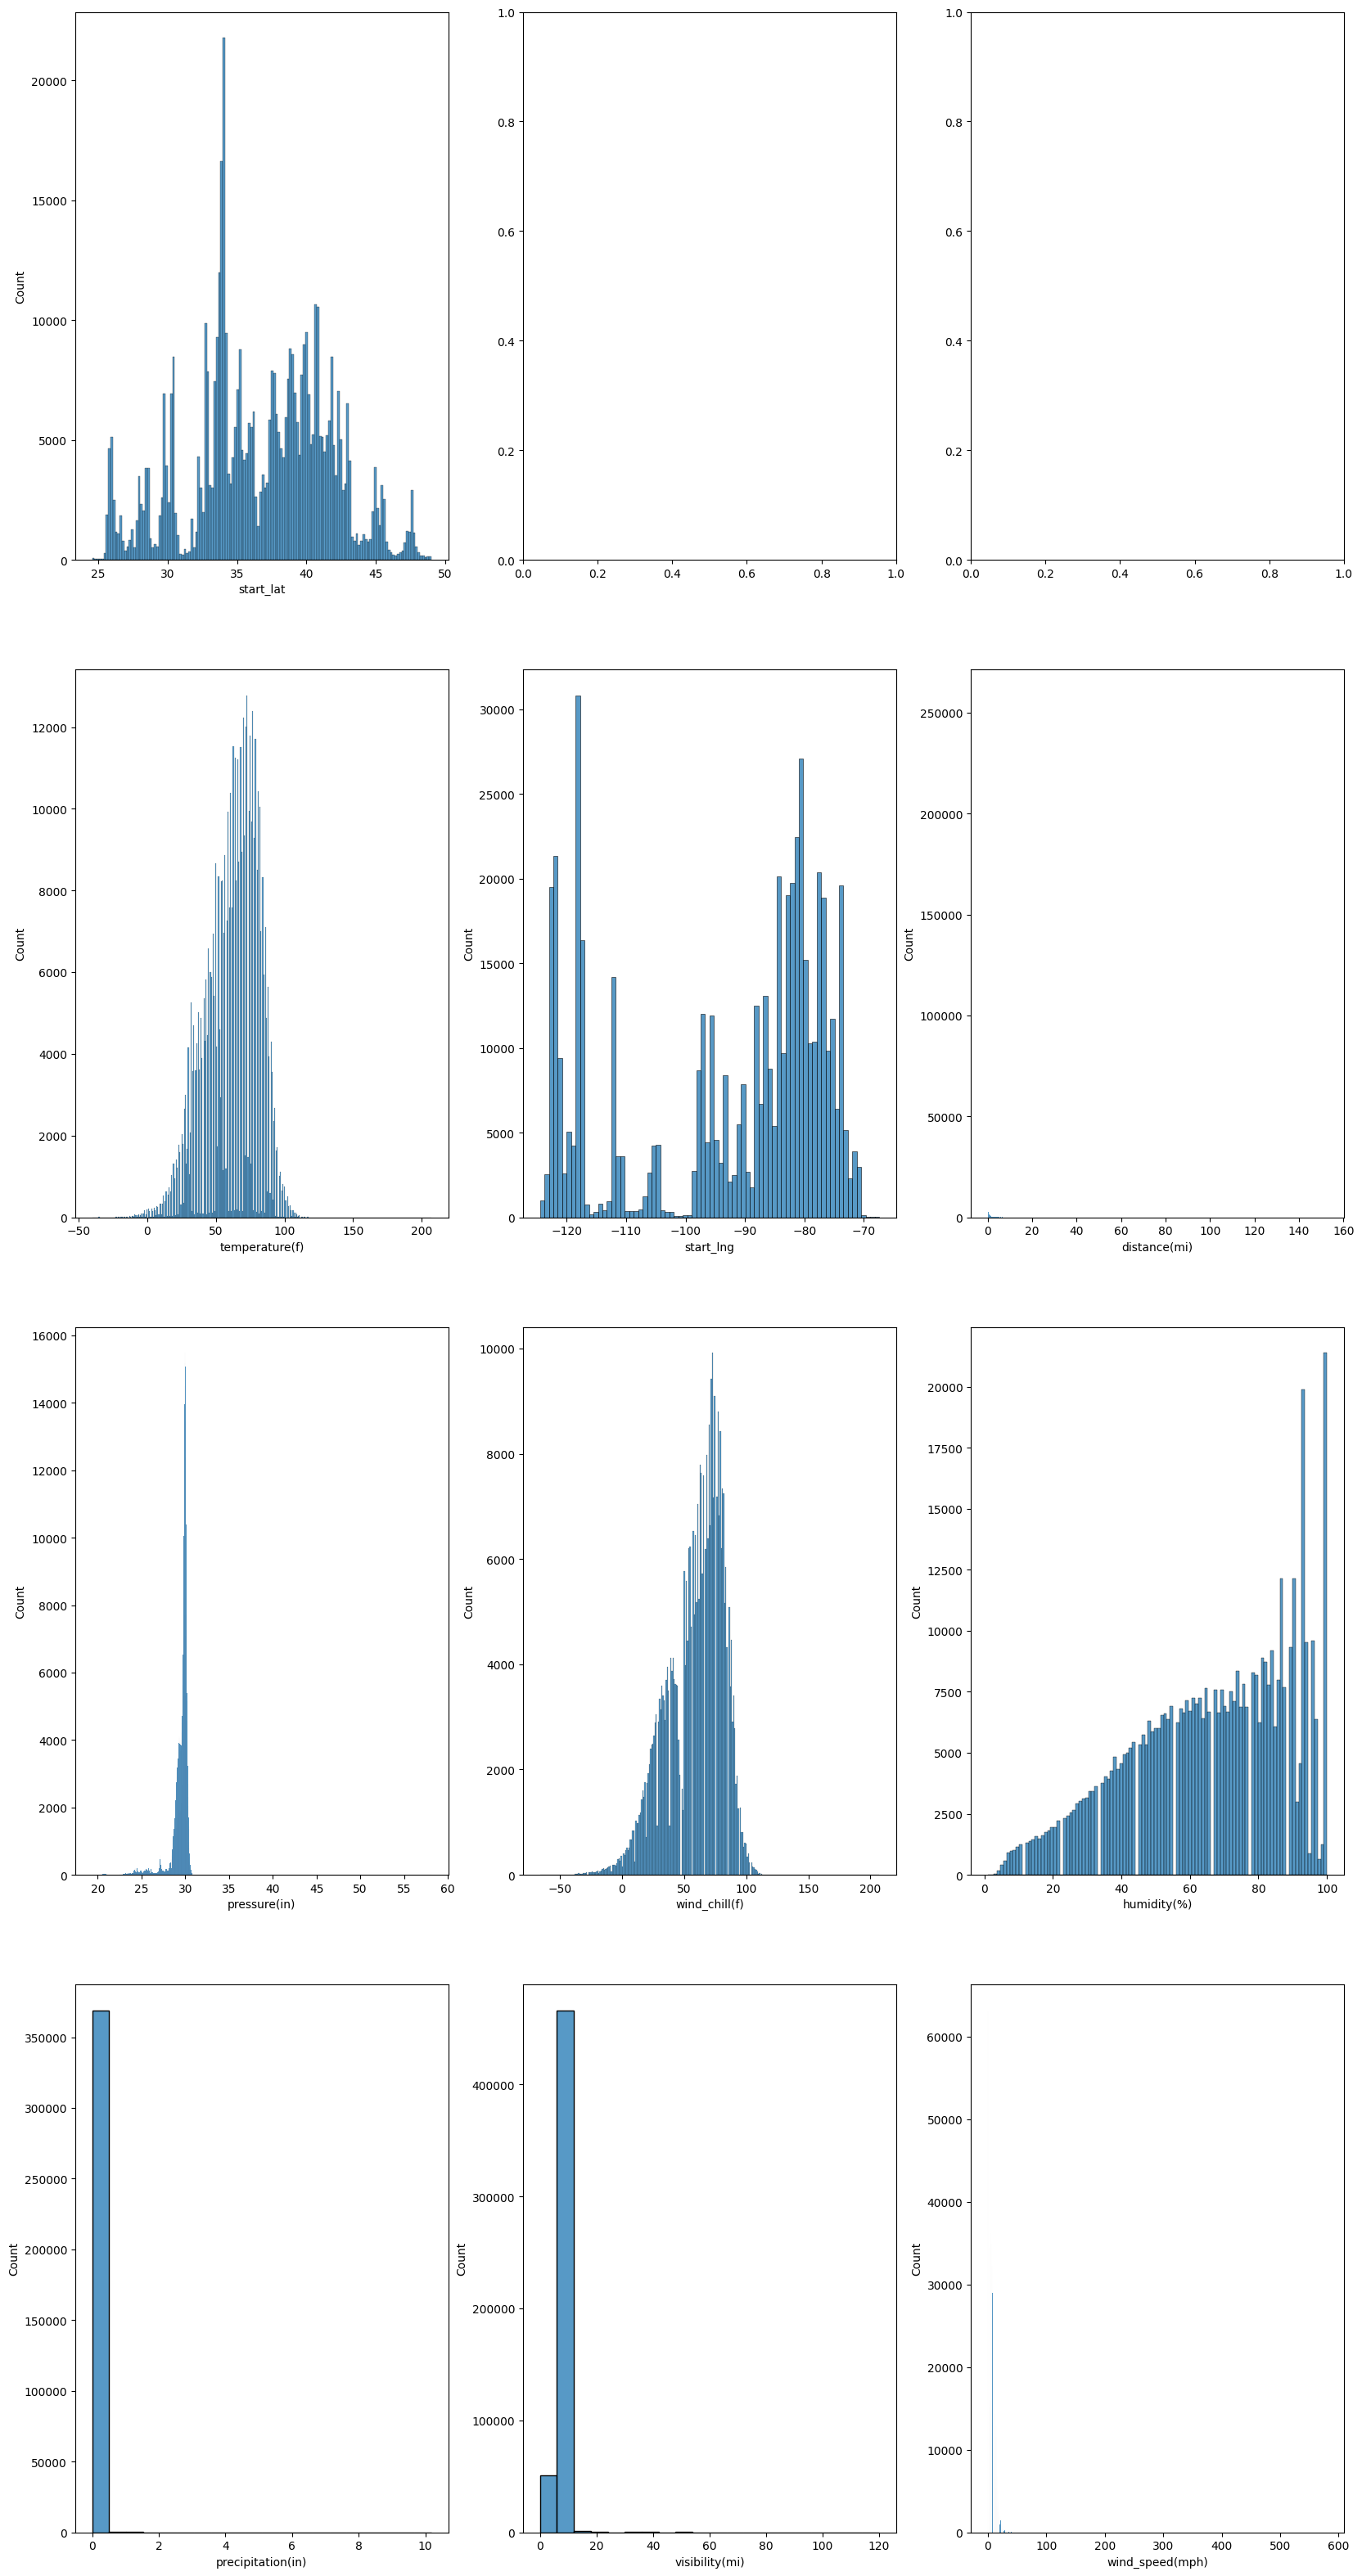

In [ ]:
N_PLOTS_PER_ROW = 3
cont_type_cols = df.select_dtypes('float64').columns
ncont_cols = len(cont_type_cols)
nrows = math.ceil(ncont_cols/N_PLOTS_PER_ROW)

fig, axs = plt.subplots(nrows=nrows, ncols=N_PLOTS_PER_ROW, figsize=(20, 40))

total = df.shape[0]

for i, col in enumerate(cont_type_cols):
    r = math.ceil(i/N_PLOTS_PER_ROW)
    c = i%N_PLOTS_PER_ROW
    axes = axs[r][c]
    sns.histplot(data=df, x = col, ax = axes)

plt.show()

## Treating noise in few features

weather_condtions, wind_direction

### 1. Binning Weather Condition Column

In [ ]:
weather_bins = {
    'Clear': ['Clear', 'Fair', 'Fair / Windy'],
    'Foggy/not clear': [
        'Patches of Fog', 'Light Freezing Fog', 'Drizzle and Fog', 'Fog / Windy', 'Smoke / Windy', 'Widespread Dust / Windy',
        'Patches of Fog / Windy', 'Partial Fog', 'Partial Fog / Windy', 'Sand / Dust Whirlwinds / Windy',
        'Blowing Sand', 'Blowing Dust / Windy','Duststorm', 'Sand / Dust Whirls Nearby'
    ],
    'Cloudy': [
        'Cloudy', 'Mostly Cloudy', 'Mostly Cloudy / Windy', 'Partly Cloudy', 'Scattered Clouds', 'Funnel Cloud', 'Sand / Dust Whirlwinds', 'Mist / Windy','Overcast'
    ],
    'Rainy': ['Light Rain', 'Rain', 'Light Freezing Drizzle', 'Light Drizzle', 'Light Freezing Rain', 'Drizzle', 'Light Rain Showers',
              'Showers in the Vicinity', 'Rain / Windy', 'Squalls', 'Thunder', 'Thunder / Windy',
               'Haze / Windy', 'Light Drizzle / Windy', 'Wintry Mix', 'Wintry Mix / Windy', 'Sleet / Windy',
              'Squalls / Windy', 'Light Rain Shower / Windy', 'Snow and Thunder / Windy', 'Light Sleet / Windy',
                'Drizzle / Windy', 'Thunder and Hail', 'Freezing Rain / Windy',
               'Thunder / Wintry Mix / Windy', 'Rain and Sleet', 'Light Hail', 'Light Thunderstorm',
              'Heavy Freezing Drizzle',  'Thunderstorms and Snow', 'Light Rain / Windy',
              'Heavy Rain Showers', 'Rain Shower / Windy', 'Sleet and Thunder', 'Thunder and Hail / Windy',
              'Heavy Sleet / Windy', 'Sand / Windy', 'Freezing Rain / Windy'
             ],
    'Extremes': [
        'Heavy Rain', 'T-Storm', 'Heavy T-Storm', 'Heavy Thunderstorms and Rain', 'Heavy T-Storm / Windy', 'Heavy Thunderstorms and Snow', 'Heavy Rain / Windy', 'tornado',
        'Heavy Ice Pellets', 'T-Storm / Windy', 'Heavy Freezing Rain / Windy', 'Heavy Snow with Thunder', 'Heavy Blowing Snow', 'Shallow Fog / Windy', 'Heavy Sleet and Thunder',
        'Heavy Thunderstorms with Small Hail', 'Hail', 'Heavy Rain Shower / Windy', 'Heavy Rain Shower', 'T-Storm / Windy', 'Heavy Rain Shower / Windy', 'Sleet and Thunder / Windy'
    ],

    'Snowy': [
        'Light Snow', 'Snow', 'Light Snow / Windy', 'Snow Grains', 'Snow Showers', 'Snow / Windy', 'Light Snow and Sleet', 'Snow and Sleet',
        'Light Snow and Sleet / Windy', 'Snow and Sleet / Windy', 'Blowing Snow / Windy','Light Snow and Sleet / Windy','Blowing Snow Nearby',
        'Blowing Snow Nearby', 'Drifting Snow','Light Snow with Thunder', 'Snow and Thunder','Light Blowing Snow','Light Snow Shower / Windy',
        'Light Snow Grains', 'Low Drifting Snow', 'Drifting Snow / Windy'
    ]
}

#changing all the values to lower case
for bin_name, bin_values in weather_bins.items():
  weather_bins[bin_name] = [val.lower() for val in bin_values]

- The above can have a few misclassifications since all the values have been scanned manually to observe a pattern and possible major categories

Following are a few along with pattern

1. Clear: contains clear or fair
2. Cloudy: contains cloud or overcast
3. Fog/Not clear: contains fog, sand, dust,smoke
4. Extreme: contains Heavy, Hail, T-Storm, sleet and not light
5. snowy: contains snow
6. Rainy: contains Rain, shower, sleet, thunder, drizzle, drizzling, winter
7. other: unmatched or unknown

In [ ]:
weather_patterns = [
      ('clear', re.compile('fair|clear',re.IGNORECASE)),
      ('cloudy', re.compile('cloud|overcast',re.IGNORECASE)),
      ('fog/notClear', re.compile('fog|sand|dust|smok(e|y)',re.IGNORECASE)),
      ('extreme', re.compile('heavy|heavily|hail|t-storm|tornado', re.IGNORECASE)), # SHOULD NOT CONTAIN word LIGHT
      ('snowy', re.compile('snow', re.IGNORECASE)),
      ('rainy', re.compile(r'rain|drizzl(e|ing)|sleet|thunder|winter|drop|shower', re.IGNORECASE))
]

def weather_mapping(weather):
  for label, pattern in weather_patterns:
    if pattern.search(str(weather)):
      return label
  return "other"

def map_weather_to_bins(weather):
  weather = str(weather).lower()
  for bin_name, bin_values in weather_bins.items():
    if weather in bin_values:
      return bin_name
  return 'Other'

In [ ]:
#USING REGEX Mapping
df['weather_bins_regex'] = df['weather_condition'].apply(weather_mapping)

In [ ]:
# USING MANUAL MAPPING
df['weather_bins_manual'] = df['weather_condition'].apply(map_weather_to_bins)

In [ ]:
df['weather_bins_regex'].value_counts(normalize=True)

clear           0.434684
cloudy          0.416021
rainy           0.070073
other           0.035842
snowy           0.019765
fog/notClear    0.014303
extreme         0.009312
Name: weather_bins_regex, dtype: float64

In [ ]:
df['weather_bins_manual'].value_counts(normalize=True)

Clear              0.434684
Cloudy             0.412572
Rainy              0.065893
Other              0.058034
Snowy              0.019626
Extremes           0.008393
Foggy/not clear    0.000797
Name: weather_bins_manual, dtype: float64

### 2. Mapping duplicate data in Wind Direction column

In [ ]:
print("Unique wind directions")
print(df['wind_direction'].unique())

Unique wind directions
['SSE' 'East' 'WNW' 'South' 'SE' 'West' 'NW' 'SSW' 'WSW' 'SW' 'Calm' nan
 'NE' 'ESE' 'NNE' 'Variable' 'NNW' 'ENE' 'North' 'E' 'S' 'CALM' 'VAR' 'N'
 'W']


In [ ]:
wind_mappings = {
    'south': ['south', 's'],
    'north': ['north', 'n'],
    'east': ['east', 'e'],
    'west': ['west', 'w'],
    'var': ['variable', 'var']
}

def map_wind_dir(wind_dir):
  wind_dir = str(wind_dir).lower()
  for label, vals in wind_mappings.items():
    if wind_dir in vals:
      return label

  return wind_dir

In [ ]:
df['wind_direction_mapped'] = df['wind_direction'].apply(map_wind_dir)

In [ ]:
df['wind_direction_mapped'].unique()

array(['sse', 'east', 'wnw', 'south', 'se', 'west', 'nw', 'ssw', 'wsw',
       'sw', 'calm', 'nan', 'ne', 'ese', 'nne', 'var', 'nnw', 'ene',
       'north'], dtype=object)

### 3. Dropping boolean columns that are 100% False

- Since, they essentially signal nothing
- There are two such features -- roundabout, turning_loop

In [ ]:
df.drop(['roundabout', 'turning_loop'], axis = 1, inplace = True)

## Treating outliers in Numeric features
- possible solutions
    - Log transformation
    - if very few are outliers remove them
    - If significant
        - check if signaling something for eg: longer distances might signal high severity. If so, find a way to include them

In [ ]:
df2 = df.copy()
df2.shape

(533514, 34)

### 1. Visibility(mi)

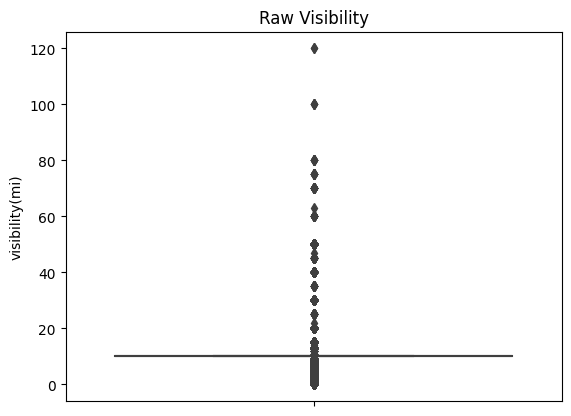

In [ ]:
sns.boxplot(data = df2, y='visibility(mi)')
plt.title("Raw Visibility")
plt.show()

In [ ]:
df2['visibility(mi)'].describe()

count    519830.000000
mean          9.137307
std           2.718925
min           0.000000
25%          10.000000
50%          10.000000
75%          10.000000
max         120.000000
Name: visibility(mi), dtype: float64

**Observation**
- Min visibility is not less than 0, that's good
- but the max is 120 Miles. That's too large even on a very clear day.
- According to stats, max visibility on a clear day of a human eye is 3-5 miles max. The range extends a little if there is an elevation.

In [ ]:
print("99.8 percentile of visibility:", df2['visibility(mi)'].quantile(0.998))
print("99.9 percentile of visibility:", df2['visibility(mi)'].quantile(0.999))

99.8 percentile of visibility: 20.0
99.9 percentile of visibility: 30.0


- 99.8% of visibility data is <= 20 miles
- 99.9% <= 30 miles

In [ ]:
chopped_df2 = df2[df2['visibility(mi)'] > df2['visibility(mi)'].quantile(0.999)]
print("Number of samples with visibility < 99.9% of data:",chopped_df2.shape[0])
print("Number of severities captured:\n", chopped_df2['severity'].value_counts(),sep='')

Number of samples with visibility < 99.9% of data: 500
Number of severities captured:
3    189
4    162
2    138
1     11
Name: severity, dtype: int64


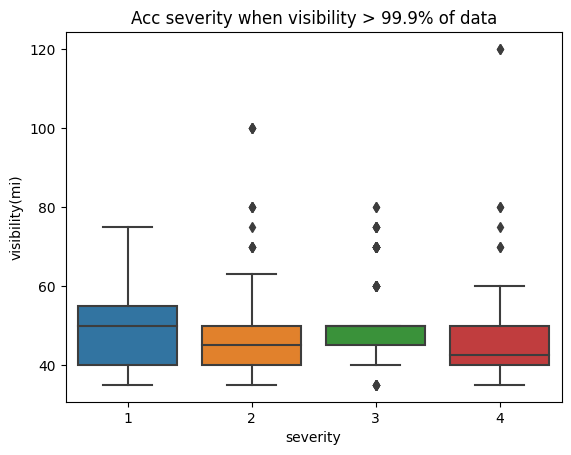

In [ ]:
sns.boxplot(data=chopped_df2, x = 'severity', y='visibility(mi)')
plt.title("Acc severity when visibility > 99.9% of data")
plt.show()

**Observation**
- Can be seen that, the outliers are highly random, and do not point to any specific case
- For eg:
    - least sever accidents have highest mean visibility among all.
    - samples are almost equally distributed among all severity levels expect 1

- Thus, very few and insignificant outliers.So, **Removing outliers**

In [ ]:
VISIBILITY_UPPER_LIMIT = df2['visibility(mi)'].quantile(0.999)
prev_tot = df2.shape[0]
df2 = df2[~df2.index.isin(chopped_df2.index)]
print(prev_tot - df2.shape[0])

500


<Axes: ylabel='visibility(mi)'>

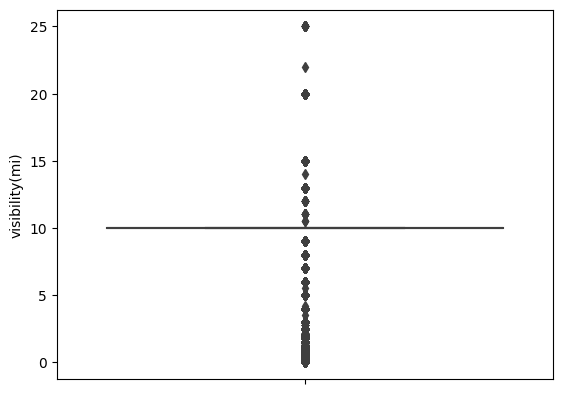

In [ ]:
sns.boxplot(data=df2, y='visibility(mi)')

In [ ]:
VISIBILITY_LOWER_LIMIT = 0 #df2['visibility(mi)'].quantile(0.001)
chopped_df2 = df2[df2['visibility(mi)'] == VISIBILITY_LOWER_LIMIT]

chopped_df2['severity'].value_counts()

2    204
4    197
1     48
3     43
Name: severity, dtype: int64

- It doesn't make sense to remove visibility outliers that are on the lower side. Since, there is a high possibility of accident when it's low
- The same is clear from above counts as well

### 2. Precipitation(in)

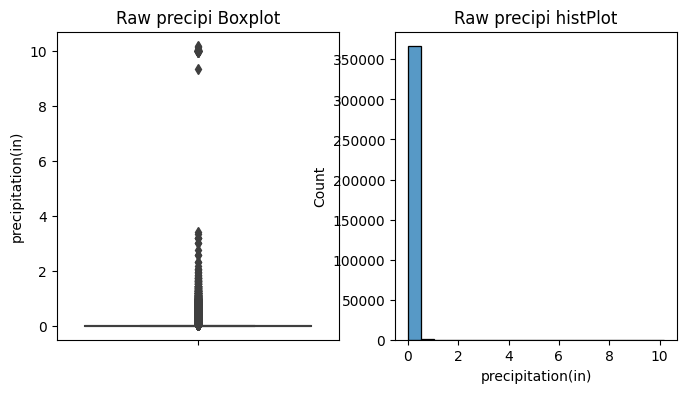

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
sns.boxplot(data = df2, y='precipitation(in)', ax = axes[0])
axes[0].set_title("Raw precipi Boxplot")
sns.histplot(data = df2, x='precipitation(in)', ax = axes[1])
axes[1].set_title("Raw precipi histPlot")
plt.show()

In [ ]:
df2['precipitation(in)'].describe()

count    366852.000000
mean          0.008943
std           0.118158
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.180000
Name: precipitation(in), dtype: float64

In [ ]:
# Since precipitation is highly correlated with weather condition,
# let's desciribe it based on weather

df2.groupby('weather_bins_regex', )['precipitation(in)'].describe()

,count,mean,std,min,25%,50%,75%,max
weather_bins_regex,,,,,,,,
clear,166012.0,0.001120,0.098269,0.0,0.00,0.00,0.00,10.05
cloudy,142328.0,0.003912,0.133930,0.0,0.00,0.00,0.00,10.18
extreme,4756.0,0.174708,0.271508,0.0,0.02,0.09,0.22,3.42
fog/notClear,6202.0,0.001421,0.015601,0.0,0.00,0.00,0.00,0.61
other,5697.0,0.013658,0.267285,0.0,0.00,0.00,0.00,10.04
rainy,34825.0,0.045214,0.094730,0.0,0.00,0.01,0.05,1.96
snowy,9582.0,0.010437,0.026811,0.0,0.00,0.00,0.01,1.43


**Observation**
- **Clear** days cannot have precipitation. 25, 50 & 75 percentile of clear shows 0 precipitation.
- Maybe a very few show extreme values. It's a **sure outlier**, if weather condition is clear

In [ ]:
PRECIPI_UPPER_LIMIT = df2['precipitation(in)'].quantile(0.9998)
print("99.99 percentile of precipitation:", PRECIPI_UPPER_LIMIT)

99.99 percentile of precipitation: 1.65


In [ ]:
chopped_df2 = df2[df2['precipitation(in)'] > PRECIPI_UPPER_LIMIT]
print("Number of samples with precipitation > 99.98% of data:",chopped_df2.shape[0])

Number of samples with precipitation > 99.98% of data: 73


In [ ]:
pd.pivot_table(data=chopped_df2, index='weather_bins_regex', columns=['severity'], values='precipitation(in)', aggfunc=np.mean)

severity,1,2,3,4
weather_bins_regex,,,,
clear,NaN,9.985000,9.996667,9.995
cloudy,NaN,9.981667,9.959333,9.990
extreme,3.051667,2.200833,1.922500,2.585
other,NaN,9.980000,10.015000,10.020
rainy,NaN,NaN,1.830000,NaN


**Observation**
- Data for extreme, rainy & snowy looks believable and fine. Since, these days are expected to show unsual precipitation levels
- Incase of Clear, these are outliers as seen before
- cloudy/overcast days shouldn't be having such high precipitation else they would be rainy days
- Anything unseen or unknown goes into other. If other with such high precipi doesn't contain lot of values we can maybe drop it

In [ ]:
print("precipi outliers in clear weather condition",chopped_df2[chopped_df2['weather_bins_regex'] == 'clear']['weather_condition'].value_counts(),sep='\n')
print("\nprecipi outliers in clody weather condition", chopped_df2[chopped_df2['weather_bins_regex'] == 'cloudy']['weather_condition'].value_counts(),sep='\n')
print("\nprecipi outliers in other weather condition",chopped_df2[chopped_df2['weather_bins_regex'] == 'other']['weather_condition'],sep='\n')
print("\nprecipi outliers in rainy weather condition",chopped_df2[chopped_df2['weather_bins_regex'] == 'rainy']['weather_condition'].value_counts(),sep='\n')
print("\nprecipi outliers in extreme weather condition",chopped_df2[chopped_df2['weather_bins_regex'] == 'extreme']['weather_condition'].value_counts(),sep='\n')

precipi outliers in clear weather condition
Clear    16
Name: weather_condition, dtype: int64

precipi outliers in clody weather condition
Overcast            22
Scattered Clouds     2
Mostly Cloudy        1
Name: weather_condition, dtype: int64

precipi outliers in other weather condition
205426    NaN
207772    NaN
508510    NaN
509212    NaN
Name: weather_condition, dtype: object

precipi outliers in rainy weather condition
Rain                       2
Light Rain with Thunder    1
Thunderstorms and Rain     1
Name: weather_condition, dtype: int64

precipi outliers in extreme weather condition
Heavy T-Storm                   13
Heavy Rain                       5
Heavy Thunderstorms and Rain     4
T-Storm / Windy                  1
T-Storm                          1
Name: weather_condition, dtype: int64


- We drop the outliers of precipitation for clear and other weather conditions
- Incase of cloudy conditions, we can treat the outliers as missing values and fill those with mean of rainy values

In [ ]:
tot_precipi_values_treated = 0

precipi_clear_outlier_indices = df2[(df2['weather_bins_regex'].isin(['clear', 'other'])) & (df2['precipitation(in)'] > PRECIPI_UPPER_LIMIT)].index
df2 = df2[~df2.index.isin(precipi_clear_outlier_indices)]

tot_precipi_values_treated = len(precipi_clear_outlier_indices)
print("Samples removed:",tot_precipi_values_treated)

533014
532994
Samples removed: 20


In [ ]:
precipi_cloudy_outlier_indices = df2[(df2['weather_bins_regex'] == 'cloudy') & (df2['precipitation(in)'] > PRECIPI_UPPER_LIMIT)].index
df2.loc[df2.index.isin(precipi_cloudy_outlier_indices),'precipitation(in)'] = df2[df2['weather_bins_regex'] == 'cloudy']['precipitation(in)'].mean()

print("values treated:", len(precipi_cloudy_outlier_indices))
tot_precipi_values_treated += len(precipi_cloudy_outlier_indices)

values treated: 25


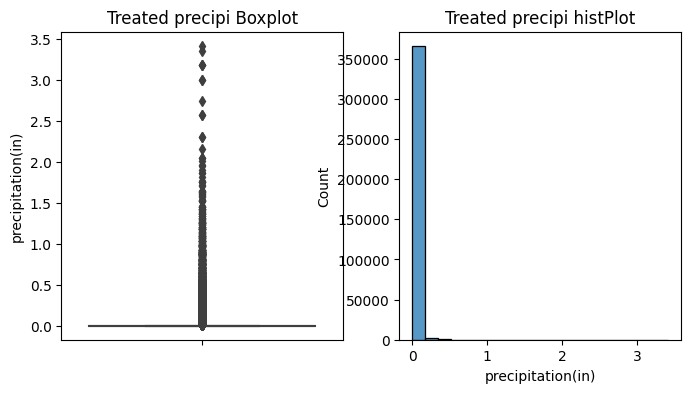

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
sns.boxplot(data = df2, y='precipitation(in)', ax = axes[0])
axes[0].set_title("Treated precipi Boxplot")
sns.histplot(data = df2, x='precipitation(in)', ax = axes[1])
axes[1].set_title("Treated precipi histPlot")
plt.show()

# Handling NaN values

temperature(f)            12547

wind_chill(f)            146003

humidity(%)               13337

pressure(in)              10816

visibility(mi)            13684

wind_direction            12845

wind_speed(mph)           43746

precipitation(in)        163956

weather_condition         13602

sunrise_sunset             2528

### Visibility(mi)

In [ ]:
visibility_nan_counts = df['visibility(mi)'].isna().sum()
visibility_zero_counts = (df['visibility(mi)'] == 0).sum()

print("Visibility(mi)\n")
print("NaN counts", visibility_nan_counts)
print("Zero counts", visibility_zero_counts)

Visibility(mi)

NaN counts 13684
Zero counts 492
Null counts 13684


*  Instead of filling the NaN values in visibility(mi) column by taking the mean of the values in the entire column, It is better to correlate visibility with weather conditions and fill NaN values accordingly.
*   Visibility is grouped by weather categories.
*   We can observe that the mean of visibilities in each weather
category is varying in range.


In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_bins_regex', y='visibility(mi)', data=df)
plt.title('Box Plot of Visibility by Weather Conditions')
plt.xlabel('Weather Conditions')
plt.ylabel('Visibility (mi)')
plt.show()

In [ ]:
df.groupby(["weather_bins_regex"])["visibility(mi)"].describe()

,count,mean,std,min,25%,50%,75%,max
weather_bins_regex,,,,,,,,
clear,231910.0,9.870166,1.364124,0.0,10.00000,10.00000,10.00000,120.0
cloudy,221953.0,9.609875,2.386662,0.0,10.00000,10.00000,10.00000,100.0
extreme,4968.0,2.999104,2.757014,0.0,1.00000,2.00000,4.00000,15.0
fog/notClear,7631.0,1.844321,2.722916,0.0,0.25000,1.00000,2.00000,50.0
other,19122.0,5.563660,1.738765,0.0,5.56366,5.56366,5.56366,40.0
rainy,37385.0,6.542870,3.236001,0.0,4.00000,7.00000,10.00000,50.0
snowy,10545.0,2.801928,2.687910,0.0,1.00000,2.00000,4.00000,12.0


Number of NaN values in visibility(mi) column belonging to each weather category.


In [ ]:
nan_counts = df.groupby(["weather_bins_regex"])["visibility(mi)"].apply(lambda x: x.isna().sum())
print(nan_counts)

weather_bins_regex
clear           0
cloudy          0
extreme         0
fog/notClear    0
other           0
rainy           0
snowy           0
Name: visibility(mi), dtype: int64


Filling NaN values in visibility(mi) column with mean of weather category to which the visibility(mi) record belongs to.

In [ ]:
visibility_weather_category_means = df.groupby('weather_bins_regex')['visibility(mi)'].transform('mean')
print(visibility_weather_category_means)

0         9.609875
1         6.542870
2         9.870166
3         2.801928
4         9.609875
            ...   
533509    9.870166
533510    9.609875
533511    9.870166
533512    9.609875
533513    6.542870
Name: visibility(mi), Length: 533514, dtype: float64


In [ ]:
df['visibility(mi)'] = df['visibility(mi)'].fillna(visibility_weather_category_means)

ValueError: ignored

### Temperature




**Columns related to temperature(f):**

weather_condition

wind_chill(f)

humidity(%)

pressure(in)

precipitation(in)

In [ ]:
temperature_nan_counts = df['temperature(f)'].isna().sum()

print("Temperature(f) NaN counts", temperature_nan_counts)

Temperature(f) NaN counts 12547


In [ ]:
df.groupby(["weather_bins_regex"])["temperature(f)"].describe()

,count,mean,std,min,25%,50%,75%,max
weather_bins_regex,,,,,,,,
clear,230839.0,64.393505,18.864678,-35.0,53.00,67.0,78.0,162.0
cloudy,221271.0,62.646752,18.349842,-40.0,50.00,65.0,77.0,207.0
extreme,4948.0,61.710812,16.128085,-9.0,54.00,66.4,73.0,93.0
fog/notClear,7590.0,53.848920,15.109588,-38.0,44.00,54.0,64.0,113.0
other,8577.0,56.949306,21.822470,-37.0,39.20,60.8,73.0,115.0
rainy,37220.0,58.915876,14.081391,-4.0,48.00,57.9,71.0,104.0
snowy,10522.0,24.768200,8.634653,-20.0,20.15,27.0,31.0,75.0


In [ ]:
temperature_nan_counts = df.groupby(["weather_bins_regex"])["temperature(f)"].apply(lambda x: x.isna().sum())

weather_bins_regex
clear            1071
cloudy            682
extreme            20
fog/notClear       41
other           10545
rainy             165
snowy              23
Name: temperature(f), dtype: int64


In [ ]:
temperature_weather_category_means = df.groupby('weather_bins_regex')['temperature(f)'].transform('mean')

0         62.646752
1         58.915876
2         64.393505
3         24.768200
4         62.646752
            ...    
533509    64.393505
533510    62.646752
533511    64.393505
533512    62.646752
533513    58.915876
Name: temperature(f), Length: 533514, dtype: float64


In [ ]:
df['temperature(f)'] = df['temperature(f)'].fillna(temperature_weather_category_means)

In [ ]:
df['weather_bins_regex'].unique()

array(['cloudy', 'rainy', 'clear', 'snowy', 'other', 'fog/notClear',
       'extreme'], dtype=object)

##wind_chill(f)

wind_chill(f) NaN values can be filled with wind_speed(mph) and temperature(f), as wind_chill is high when temperature(f) is low and wind_speed(mph) is high and vice-versa ??

In [ ]:
wind_chill_nan_counts = df['wind_chill(f)'].isna().sum()

print("wind_chill(f) NaN counts", wind_chill_nan_counts)

wind_chill(f) NaN counts 146003


Text(0.5, 1.0, 'Wind Chill and Temperature relation')

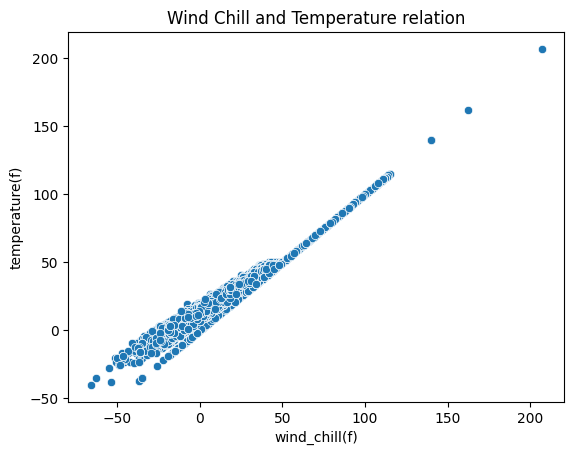

In [ ]:
# Here, wind_chill(f) and temperature(f) are plotted, we can observe that they are positively
# correlated.
sns.scatterplot(x='wind_chill(f)', y='temperature(f)', data=df)
plt.xlabel('wind_chill(f)')
plt.ylabel('temperature(f)')
plt.title("Wind Chill and Temperature relation")

<Axes: >

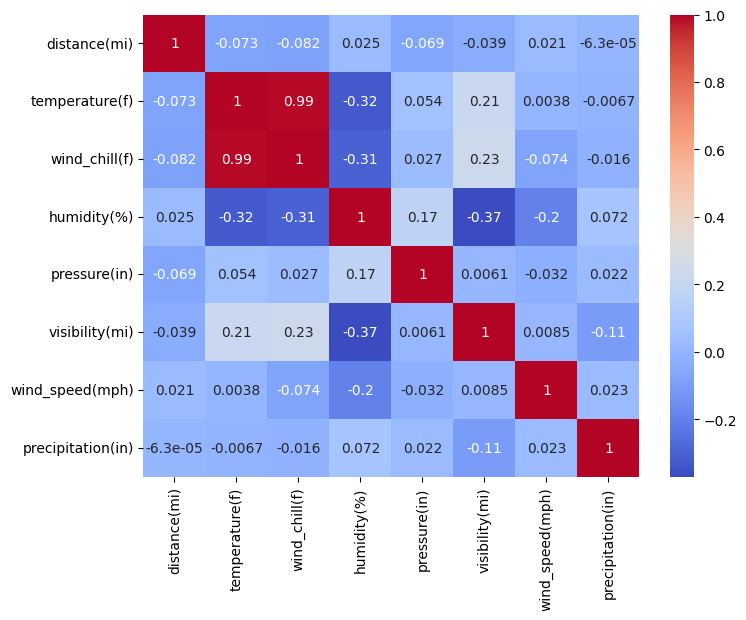

In [ ]:
numeric_values = df.loc[:, ['distance(mi)', 'temperature(f)', 'wind_chill(f)', 'humidity(%)', 'pressure(in)', 'visibility(mi)',
                        'wind_speed(mph)', 'precipitation(in)']]
corr_matrix = numeric_values.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

*   From the heatmap, we can observe that wind_chill(f) and temperature(f) are highly correlated.
*   Hence, dropping wind_chill(f) column.






In [ ]:
df.drop(columns=['wind_chill(f)'], inplace=True)

humidity(%)

temperature is high -> humidity can be high & vice-versa?

precipitation is high -> humidity is high & vice-versa?

In [ ]:
print("humidity(%) NaN counts: ", df['humidity(%)'].isna().sum())

# calculate mean and fill the NaN values in humidity
df['humidity(%)'].fillna(df['humidity(%)'].mean(), inplace = True)

humidity(%) NaN counts:  0


Precipitation(in)

Approx 3L records have precipitation(in) as zero.

Approx 1.6L records have NaN precipitation(in). Drop?

In [ ]:
precipitation_zero_counts = (df['precipitation(in)'] == 0.0).sum()
precipitation_nan_counts = df['precipitation(in)'].isna().sum()

print("Zero precipitation counts", precipitation_zero_counts)
print("NaN precipitation counts", precipitation_nan_counts)

Zero precipitation counts 332909
NaN precipitation counts 163956


Pressure(in)

In [ ]:
print("pressure(in) NaN counts", df['pressure(in)'].isna().sum())

# filling NaN values in pressure(in) using mean
df['pressure(in)'].fillna(df['pressure(in)'].mean(), inplace = True)

pressure(in) NaN counts 0


Wind Direction

In [ ]:
df['wind_direction'].fillna(df['wind_direction'].mode(), inplace = True)

Wind Speed(mph)

In [ ]:
df['wind_speed(mph)'].fillna(df['wind_speed(mph)'].mean(), inplace = True)

weather_condition

In [ ]:
df['weather_condition'].unique()

array(['Overcast', 'Light Rain', 'Clear', 'Light Snow',
       'Scattered Clouds', 'Mostly Cloudy', 'Haze', nan, 'Rain',
       'Light Freezing Drizzle', 'Partly Cloudy', 'Light Freezing Fog',
       'Snow', 'Fog', 'Heavy Rain', 'Light Drizzle',
       'Thunderstorms and Rain', 'Smoke', 'Fair', 'Cloudy',
       'Blowing Sand', 'Widespread Dust', 'Rain Showers', 'Drizzle',
       'Showers in the Vicinity', 'Light Thunderstorms and Rain', 'Mist',
       'Patches of Fog', 'Thunderstorm', 'Heavy Thunderstorms and Rain',
       'Thunder in the Vicinity', 'Thunder', 'Light Freezing Rain',
       'Shallow Fog', 'Heavy Snow', 'Light Ice Pellets',
       'Partly Cloudy / Windy', 'Light Fog', 'Fair / Windy',
       'Ice Pellets', 'Small Hail', 'Heavy T-Storm', 'Funnel Cloud',
       'Light Rain Showers', 'T-Storm', 'Light Rain with Thunder',
       'Heavy T-Storm / Windy', 'Thunder / Windy', 'Light Rain / Windy',
       'Mostly Cloudy / Windy', 'Cloudy / Windy', 'T-Storm / Windy',
       'Heavy 

In [ ]:
df['weather_condition'].fillna(df['weather_condition'].mode(), inplace = True)